# ART - Adversarial Patch - PyTorch - YOLO v3

In [1]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np

from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch

import cv2
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

# Helper functions and Labels

In [2]:
COCO_CATEGORIES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_):
    # Get the predicted class
    predictions_class = [COCO_CATEGORIES[i] for i in list(predictions_["labels"])]

    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])

    predictions_boxes = [[tuple([int (i) for i in t]) for t in r] for r in predictions_boxes]

    return predictions_class, predictions_boxes, predictions_class


def plot_image_with_boxes(img, boxes, pred_cls):
    text_size = 1
    text_th = 3
    rect_th = 3
    
    for i in range(len(boxes)):
        
        color = tuple([int(i) for i in list(np.random.choice(range(256), size=3))])
        
        # Draw Rectangle with the coordinates
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=color, thickness=rect_th)

        # Write the prediction class
        cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, color, thickness=text_th)

    plt.axis("off")
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

# Attack Settings

In [3]:
rotation_max=22.5
scale_min=0.4
scale_max=1.0
learning_rate=5.
batch_size=16
max_iter=50
patch_shape=(3, 640, 640)

# Model definition

In [4]:
class YoloV3(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model(x)
            # loss is averaged over a batch. Thus, for patch generation use batch_size = 1
            loss, loss_components = compute_loss(outputs, targets, self.model)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)

model_path = "./../../yolov3.cfg"
weights_path = "./../../yolov3.weights"
model = load_model(model_path=model_path, weights_path=weights_path)
        
model = YoloV3(model)

detector = PyTorchYolo(model=model,
                       device_type='cpu',
                       input_shape=(3, 640, 640),
                       clip_values=(0, 255), 
                       attack_losses=("loss_total",))

# Example images

In [5]:
response = requests.get('https://ultralytics.com/images/zidane.jpg')
image_zidane = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
image_zidane = image_zidane.transpose(2,0,1)
image_zidane = np.stack([image_zidane], axis=0).astype(np.float32) 
image_zidane = image_zidane.copy()

response = requests.get('https://farm5.staticflickr.com/4092/5049609764_d83c7ba9f5_z.jpg')
image_kitchen = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
image_kitchen = image_kitchen.transpose(2,0,1)
image_kitchen = np.stack([image_kitchen], axis=0).astype(np.float32) 
image_kitchen = image_kitchen.copy()

-------
Yolov5 predictions for original image:
     scores  labels
0  0.999513       0
1  0.998428       0
2  0.997855       0
3  0.995262       0
4  0.973592       0
5  0.957903       0
6  0.957623       0
7  0.956354       0
8  0.919625       0
9  0.916126       0


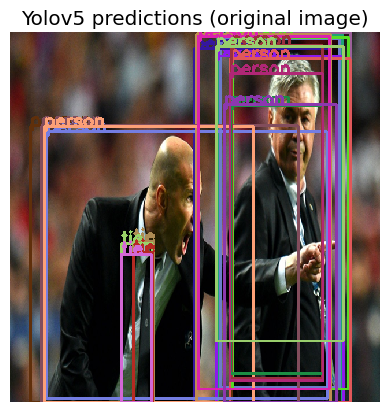

In [6]:
predictions = detector.predict(x=image_zidane)[0]


threshold = 0.5
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=image_zidane[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

-------
Yolov5 predictions for original image:
     scores  labels
0  0.999548      72
1  0.995328      72
2  0.911584      58
3  0.888703      58
4  0.875733      71
5  0.861711      74
6  0.841588      72
7  0.765890      72
8  0.754062      58
9  0.730629      56


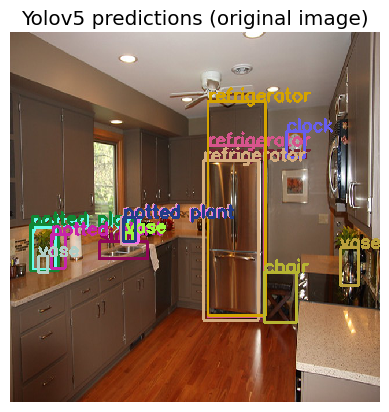

In [7]:
predictions = detector.predict(x=image_kitchen)[0]


threshold = 0.5
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=image_kitchen[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

# Adversarial patch generation

In [8]:
target = detector.predict(image_zidane)

ap = AdversarialPatchPyTorch(
            estimator=detector,
            rotation_max=rotation_max,
            scale_min=scale_min,
            scale_max=scale_max,
            learning_rate=learning_rate,
            batch_size=batch_size,
            max_iter=max_iter,
            patch_shape=patch_shape,
            verbose=True,
        )

patch, patch_mask = ap.generate(x=image_zidane, y=target)

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/kieranfraser/git/personal/adversarial-robustness-toolbox/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/kieranfraser/git/personal/adversarial-robustness-toolbox/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:675: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/kieranfraser/git/personal/adversarial-robustness-toolbox/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1135: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(


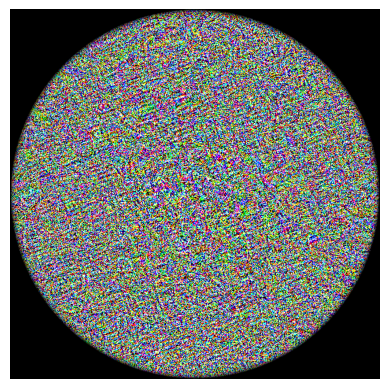

In [9]:
plt.axis("off")
plt.imshow((patch * patch_mask).transpose(1,2,0).astype(np.uint8))
plt.show()

# Evaluation

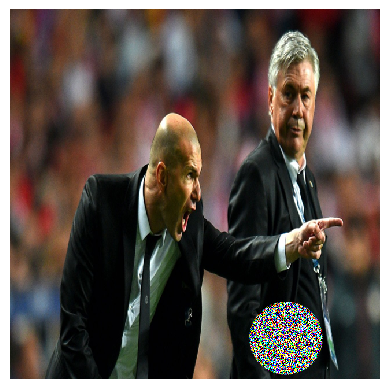

In [10]:
plt.axis("off")
patched_image = ap.apply_patch(image_zidane, scale=0.2)
plt.imshow(patched_image[0].transpose(1,2,0).astype(np.uint8), interpolation="nearest")

-------
Yolov3 predictions for malformed detector(?) original image:
     scores  labels
0  0.000447      66
1  0.000441      66
2  0.000424      66
3  0.000418      66
4  0.000416      66
5  0.000394      66
6  0.000381      66
7  0.000358      66
8  0.000344      66
9  0.000314      66


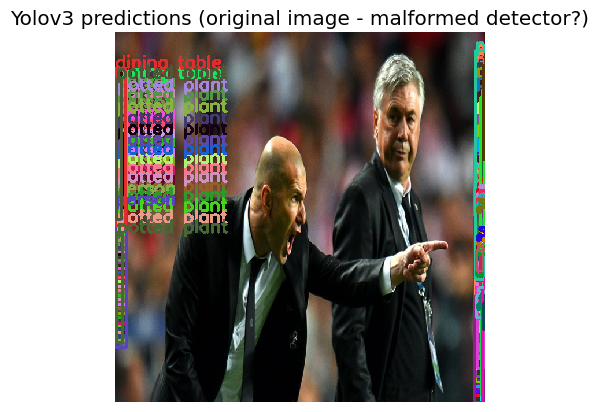

In [11]:
predictions = detector.predict(x=image_zidane)[0]


threshold = 0.00001
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov3 predictions for malformed detector(?) original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov3 predictions (original image - malformed detector?)")
# Plot predictions
plot_image_with_boxes(img=image_zidane[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

-------
Yolov3 predictions for patched image:
     scores  labels
0  0.000448      66
1  0.000444      66
2  0.000426      66
3  0.000425      66
4  0.000418      66
5  0.000396      66
6  0.000383      66
7  0.000370      66
8  0.000345      66
9  0.000314      66


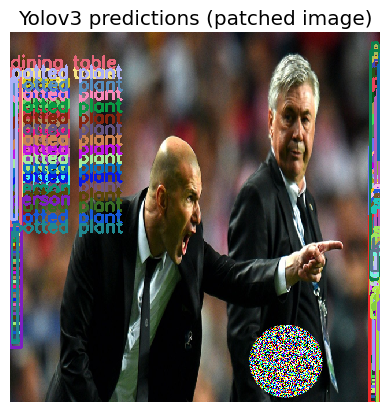

In [12]:
predictions = detector.predict(x=patched_image)[0]


threshold = 0.00001
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov3 predictions for patched image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov3 predictions (patched image)")
# Plot predictions
plot_image_with_boxes(img=patched_image[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

### Prediction on patched image with fresh detector

In [14]:
class YoloV3(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model(x)
            # loss is averaged over a batch. Thus, for patch generation use batch_size = 1
            loss, loss_components = compute_loss(outputs, targets, self.model)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)

model_path = "./../../yolov3.cfg"
weights_path = "./../../yolov3.weights"
model = load_model(model_path=model_path, weights_path=weights_path)
        
model = YoloV3(model)

detector = PyTorchYolo(model=model,
                       device_type='cpu',
                       input_shape=(3, 640, 640),
                       clip_values=(0, 255), 
                       attack_losses=("loss_total",))

-------
Yolov5 predictions for original image:
     scores  labels
0  0.999693       0
1  0.999200       0
2  0.998234       0
3  0.993767       0
4  0.993333       0
5  0.975730       0
6  0.968849       0
7  0.942919       0
8  0.942383       0
9  0.941513       0


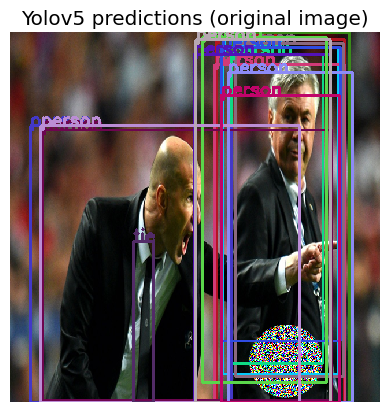

In [16]:
predictions = detector.predict(x=patched_image)[0]


threshold = 0.8
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=patched_image[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class) 